# Whitened PSD

* **author**: steeve.laquitaine@epfl.ch

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: 
    * PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * `Horvath` (aligned with cortical column)
        * rat cortex S1
        * 128ch
        * 30.0kHz
        * Horvath in vivo probe 1:
            * duration: 3606.552 (~60 mins)
        * Horvath in vivo probe 2:
            * duration: 3688.668 secs (~61 mins)
        * Horvath in vivo probe 3:
            * duration: 3603.096 secs (~60 mins)  
        * "Spontaneous activity" (Only anesthetized condition)
    * `high-density (Horvath)` (aligned with cortical column)
        * run: 2023_10_18
        * rat cortex S1
        * 384ch 
        * 40.0kHz
        * 10 min
        * "Spontaneous activity" (Only anesthetized condition)
        * fitted gain and noise + fine tuned gain
        * Silico probe 1
            * duration: 1175.9988 secs (~28 min)
        * Silico probe 2   
            * duration: 1714.99825 secs (~19 min)
        * Silico probe 3: 
            * duration: 1763.9982 secs  (~29 min)
    * `Buccino`:
        * 10 min
    * Welch method
        * 1Hz resolution, Hann window
    * The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
    and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

    $$f_r = f_s / N$$

    * We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
    * To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
    * We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).

### Setup

1. Activate `spikeinterf..` venv

2. Compute power spectral data with: 

    ```bash
    # neuropixels (Marques & biophy. spontaneous)
    sbatch cluster/validation/psd/psd_welch_buttw_fitd_horv_10m.sbatch # 5 min
    sbatch cluster/validation/psd/psd_welch_buttw_fitd_npx_10m.sbatch # 16 min
    ```

In [317]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
SFREQ_HV = 20000          # sampling frequency
SFREQ_HS = 20000        # sampling frequency
SFREQ_MV = 30000          # sampling frequency
SFREQ_MS = 40000        # sampling frequency
SFREQ_B = 32000

# SETUP DATASETS

# neuropixels *********************

# neuropixels (Marques-Smith)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["probe_wiring"]["output"]
PREP_PATH_nv = cfg_nv["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_NV = cfg_nv["validation"]["psd"]["raw"]
PRE_PSD_PATH_NV = cfg_nv["validation"]["psd"]["preprocessed"]

# neuropixels (biophy. spont.)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["40m"]["output_noise_fitd_gain_fitd_adj10perc_less_int16"]
PREP_PATH_ns = cfg_ns["preprocessing"]["output"]["40m"]["trace_file_path_gain_fitd_adj10perc_less_noise_fitd_int16"]
RAW_PSD_PATH_NS = cfg_ns["validation"]["psd"]["raw"]
PRE_PSD_PATH_NS = cfg_ns["validation"]["psd"]["preprocessed"]

# neuropixels (evoked biophy.)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["output"]
PREP_PATH_ne = cfg_ne["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_NE = cfg_ne["validation"]["psd"]["raw"]
PRE_PSD_PATH_NE = cfg_ne["validation"]["psd"]["preprocessed"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
RAW_PSD_PATH_NB = cfg_nb["validation"]["psd"]["raw"]
PRE_PSD_PATH_NB = cfg_nb["validation"]["psd"]["preprocessed"]

# custom *******************
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["probe_wiring"]["output"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["probe_wiring"]["output"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["probe_wiring"]["output"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["preprocessed"]
# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs1 = cfg_hs1["probe_wiring"]["output"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs2 = cfg_hs2["probe_wiring"]["output"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs3 = cfg_hs3["probe_wiring"]["output"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["preprocessed"]


# # neuro 


# FIGURE SETTINGS
# sampling frequency
SFREQ_NV = 30000        
SFREQ_NS = 40000
SFREQ_NE = 20000
SFREQ_NB = 32000
SFREQ_HV = 20000        
SFREQ_HS = 20000


# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
COLOR_NV = [0.4, 0.4, 0.4]
COLOR_NS = [0.9, 0.14, 0.15]
#COLOR_HV = [0.75, 0.75, 0.75] # light
#COLOR_HS = [0.9, 0.64, 0.65] # light
COLOR_NB = [0.22, 0.5, 0.72]
COLOR_NE = [1, 0.49, 0]

COLOR_HV = "k"
COLOR_HS = np.array([26, 152, 80]) / 255

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-06-26 19:12:46,480 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-26 19:12:46,679 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-26 19:12:46,681 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-26 19:12:46,882 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-26 19:12:46,885 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-26 19:12:46,939 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-26 19:12:46,941 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-26 19:12:46,989 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-26 19:12:46,991 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-26 19:12:47,043 - root - utils.py - get_config - INFO - R

### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 72
available gpus: True


['              total        used        free      shared  buff/cache   available',
 'Mem:         772341       59324      711842          70        1174      711380',
 'Swap:             0           0           0']

### (1s)Load dataset

* select first 10 min for speed

In [451]:
# Load traces
# neuropixels
# raw
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
# preprocessed
PrepNV = si.load_extractor(PREP_PATH_nv)
PrepNS = si.load_extractor(PREP_PATH_ns)
PrepNE = si.load_extractor(PREP_PATH_ne)

# horvath
# raw (probe 1)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
# raw (probe 2)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
# raw (probe 3)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)
# preprocessed (probe 1)
PrepHV1 = si.load_extractor(PREP_PATH_hv1)
PrepHS1 = si.load_extractor(PREP_PATH_hs1)
# preprocessed (probe 2)
PrepHV2 = si.load_extractor(PREP_PATH_hv2)
PrepHS2 = si.load_extractor(PREP_PATH_hs2)
# preprocessed (probe 3)
PrepHV3 = si.load_extractor(PREP_PATH_hv3)
PrepHS3 = si.load_extractor(PREP_PATH_hs3)


# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs
# neuropuxels
# raw
psd_raw_nv = np.load(RAW_PSD_PATH_NV, allow_pickle=True).item()
psd_raw_ns = np.load(RAW_PSD_PATH_NS, allow_pickle=True).item()
psd_raw_ne = np.load(RAW_PSD_PATH_NE, allow_pickle=True).item()
psd_raw_nb = np.load(RAW_PSD_PATH_NB, allow_pickle=True).item()
# preprocessed
psd_pre_nv = np.load(PRE_PSD_PATH_NV, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()

# custom (Horvath)
psd_raw_hv1 = np.load(RAW_PSD_PATH_HV1, allow_pickle=True).item()
psd_raw_hv2 = np.load(RAW_PSD_PATH_HV2, allow_pickle=True).item()
psd_raw_hv3 = np.load(RAW_PSD_PATH_HV3, allow_pickle=True).item()
psd_raw_hs1 = np.load(RAW_PSD_PATH_HS1, allow_pickle=True).item()
psd_raw_hs2 = np.load(RAW_PSD_PATH_HS2, allow_pickle=True).item()
psd_raw_hs3 = np.load(RAW_PSD_PATH_HS3, allow_pickle=True).item()
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_raw_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

#### (2m) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

### (1s)Plot

plot avg

    silico:
        first band: 0-70Hz -> better 0 - 90Hz
        2nd band: 70 - 2000 --> better 0 - 110Hz
        2nd band: 2500 - 200Nyquist

Normalizing psds, plotting three on the left y-scale and horvath vivo on a different y-scale was the only way to compare all psds on the same plot.

#### plot layer 1 
* probe 1 for horvath

##### Compute data

In [492]:
# get L1 data  ***********************

layer = "L1"

# horvath vivo (probe 1)
psd_raw_hv1_ = copy.copy(psd_raw_hv1)
psd_raw_hv1_["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == layer, :]

# biophy
psd_raw_hs1_ = copy.copy(psd_raw_hs1)
psd_raw_hs1_["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]

# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]

# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]

# (11s) Divide by total power ***********************

psd_raw_hv1_["power"] = (
    psd_raw_hv1_["power"] / psd_raw_hv1_["power"].sum(axis=1)[:, None]
)
psd_raw_hs1_["power"] = (
    psd_raw_hs1_["power"] / psd_raw_hs1_["power"].sum(axis=1)[:, None]
)
psd_raw_nv_["power"] = psd_raw_nv_["power"] / psd_raw_nv_["power"].sum(axis=1)[:, None]
psd_raw_ns_["power"] = psd_raw_ns_["power"] / psd_raw_ns_["power"].sum(axis=1)[:, None]
psd_raw_ne_["power"] = psd_raw_ne_["power"] / psd_raw_ne_["power"].sum(axis=1)[:, None]


# (11s) Average over sites ***********************

# horvath
# in vivo
psd_mean_raw_hv1 = np.mean(psd_raw_hv1_["power"], axis=0)
# biophy
psd_mean_raw_hs1 = np.mean(psd_raw_hs1_["power"], axis=0)

# neuropixels
# raw
psd_mean_raw_nv = np.mean(psd_raw_nv_["power"], axis=0)
psd_mean_raw_ns = np.mean(psd_raw_ns_["power"], axis=0)
psd_mean_raw_ne = np.mean(psd_raw_ne_["power"], axis=0)

# Calculate 95% confidence intervals  ******************

# horvath
# vivo
# probe 1
n_samples = psd_raw_hv1_["power"].shape[0]
ci_raw_hv1 = 1.96 * np.std(psd_raw_hv1_["power"], axis=0) / np.sqrt(n_samples)

# biophy.
# probe 1
n_samples = psd_raw_hs1_["power"].shape[0]
ci_raw_hs1 = 1.96 * np.std(psd_raw_hs1_["power"], axis=0) / np.sqrt(n_samples)

# neuropixels
# vivo
n_samples = psd_raw_nv_["power"].shape[0]
ci_raw_nv = 1.96 * np.std(psd_raw_nv_["power"], axis=0) / np.sqrt(n_samples)
# biophy. spont.
n_samples = psd_raw_ns_["power"].shape[0]
ci_raw_ns = 1.96 * np.std(psd_raw_ns_["power"], axis=0) / np.sqrt(n_samples)
# biophy. evoked
n_samples = psd_raw_ne_["power"].shape[0]
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)

##### plot 

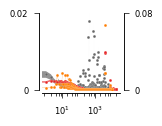

In [522]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

# 3 secs
# spontaneous
# - this order for visibility
ax1.plot(psd_raw_nv_["freq"], psd_mean_raw_nv, label="vivo", color=COLOR_NV, **pm)
ax1.plot(psd_raw_ns_["freq"], psd_mean_raw_ns, color=COLOR_NS, label="silico", **pm)

# evoked
ax2 = ax1.twinx()
ax2.plot(psd_raw_ne_["freq"], psd_mean_raw_ne, color=COLOR_NE, label="silico", **pm)

# confidence interval
# - this order for visibility
ax1.fill_between(
    psd_raw_nv_["freq"],
    (psd_mean_raw_nv - ci_raw_nv),
    (psd_mean_raw_nv + ci_raw_nv),
    color=COLOR_NV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax1.fill_between(
    psd_raw_ns_["freq"],
    (psd_mean_raw_ns - ci_raw_ns),
    (psd_mean_raw_ns + ci_raw_ns),
    color=COLOR_NS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_ne_["freq"],
    (psd_mean_raw_ne - ci_raw_ne),
    (psd_mean_raw_ne + ci_raw_ne),
    color=COLOR_NE,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L1_npx_raw_norm_psd.svg", **savefig_cfg
)

### Custom probe (Horvath)

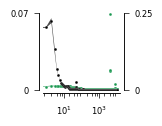

In [454]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.07]
YLIM_AX2 = [0, 0.25]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)


# Raw panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

# 3 secs
# spontaneous
# - this order for visibility
ax1.plot(psd_raw_hs1_["freq"], psd_mean_raw_hs1, color=COLOR_HS, label="silico", **pm)

# horvath vivo
ax2 = ax1.twinx()
ax2.plot(psd_raw_hv1_["freq"], psd_mean_raw_hv1, label="vivo", color=COLOR_HV, **pm)

# confidence interval
# - this order for visibility
ax1.fill_between(
    psd_raw_hv1_["freq"],
    (psd_mean_raw_hs1 - ci_raw_hs1),
    (psd_mean_raw_hs1 + ci_raw_hs1),
    color=COLOR_HS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_hv1_["freq"],
    (psd_mean_raw_hv1 - ci_raw_hv1),
    (psd_mean_raw_hv1 + ci_raw_hv1),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L1_horv_raw_norm_psd.svg", **savefig_cfg
)

#### plot layer 2/3

In [455]:
# get L2_3 data  ***********************

layer = "L2_3"

# horvath vivo (probe 1)
psd_raw_hv1_ = copy.copy(psd_raw_hv1)
psd_raw_hv1_["power"] = psd_raw_hv1["power"][site_ly_hv1[sites_hv1] == layer, :]

# biophy
psd_raw_hs1_ = copy.copy(psd_raw_hs1)
psd_raw_hs1_["power"] = psd_raw_hs1["power"][site_ly_hs1[sites_hs1] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]

# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]

# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]

# (11s) Divide by total power ***********************

psd_raw_hv1_["power"] = (
    psd_raw_hv1_["power"] / psd_raw_hv1_["power"].sum(axis=1)[:, None]
)
psd_raw_hs1_["power"] = (
    psd_raw_hs1_["power"] / psd_raw_hs1_["power"].sum(axis=1)[:, None]
)
psd_raw_nv_["power"] = psd_raw_nv_["power"] / psd_raw_nv_["power"].sum(axis=1)[:, None]
psd_raw_ns_["power"] = psd_raw_ns_["power"] / psd_raw_ns_["power"].sum(axis=1)[:, None]
psd_raw_ne_["power"] = psd_raw_ne_["power"] / psd_raw_ne_["power"].sum(axis=1)[:, None]


# (11s) Average over sites ***********************

# horvath
# in vivo
psd_mean_raw_hv1 = np.mean(psd_raw_hv1_["power"], axis=0)
# biophy
psd_mean_raw_hs1 = np.mean(psd_raw_hs1_["power"], axis=0)

# neuropixels
# raw
psd_mean_raw_nv = np.mean(psd_raw_nv_["power"], axis=0)
psd_mean_raw_ns = np.mean(psd_raw_ns_["power"], axis=0)
psd_mean_raw_ne = np.mean(psd_raw_ne_["power"], axis=0)

# Calculate 95% confidence intervals  ******************

# horvath
# vivo
# probe 1
n_samples = psd_raw_hv1_["power"].shape[0]
ci_raw_hv1 = 1.96 * np.std(psd_raw_hv1_["power"], axis=0) / np.sqrt(n_samples)

# biophy.
# probe 1
n_samples = psd_raw_hs1_["power"].shape[0]
ci_raw_hs1 = 1.96 * np.std(psd_raw_hs1_["power"], axis=0) / np.sqrt(n_samples)

# neuropixels
# vivo
n_samples = psd_raw_nv_["power"].shape[0]
ci_raw_nv = 1.96 * np.std(psd_raw_nv_["power"], axis=0) / np.sqrt(n_samples)
# biophy. spont.
n_samples = psd_raw_ns_["power"].shape[0]
ci_raw_ns = 1.96 * np.std(psd_raw_ns_["power"], axis=0) / np.sqrt(n_samples)
# biophy. evoked
n_samples = psd_raw_ne_["power"].shape[0]
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)

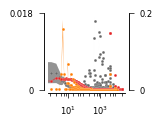

In [457]:
FIG_SIZE = (1, 1)
# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.018]
YLIM_AX2 = [0, 0.2]

pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# 3 secs
# spontaneous
ax1.plot(psd_raw_nv_["freq"], psd_mean_raw_nv, label="vivo", color=COLOR_NV, **pm)
ax1.plot(psd_raw_ns_["freq"], psd_mean_raw_ns, color=COLOR_NS, label="silico", **pm)

# evoked
ax2 = ax1.twinx()
ax2.plot(psd_raw_ne_["freq"], psd_mean_raw_ne, color=COLOR_NE, label="silico", **pm)

# confidence interval
ax1.fill_between(
    psd_raw_nv_["freq"],
    (psd_mean_raw_nv - ci_raw_nv),
    (psd_mean_raw_nv + ci_raw_nv),
    color=COLOR_NV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax1.fill_between(
    psd_raw_ns_["freq"],
    (psd_mean_raw_ns - ci_raw_ns),
    (psd_mean_raw_ns + ci_raw_ns),
    color=COLOR_NS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_ne_["freq"],
    (psd_mean_raw_ne - ci_raw_ne),
    (psd_mean_raw_ne + ci_raw_ne),
    color=COLOR_NE,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# # axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# ax1.set_xlabel("frequency [Hz]")
# ax1.set_ylabel("Power ($\mu V^2$/Hz)")
# esthetics
ax1.set_xscale("log")
ax2.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save (12MB figure)
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L23_npx_raw_norm_psd.svg", **savefig_cfg
)

#### Custom probe

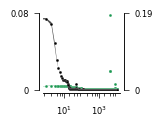

In [458]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.08]
YLIM_AX2 = [0, 0.19]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo
ax2 = ax1.twinx()

# Raw panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

# 3 secs
# spontaneous
# - this order for visibility
ax1.plot(psd_raw_hs1_["freq"], psd_mean_raw_hs1, color=COLOR_HS, label="silico", **pm)
ax2.plot(psd_raw_hv1_["freq"], psd_mean_raw_hv1, label="vivo", color=COLOR_HV, **pm)

# confidence interval
# - this order for visibility
ax1.fill_between(
    psd_raw_hv1_["freq"],
    (psd_mean_raw_hs1 - ci_raw_hs1),
    (psd_mean_raw_hs1 + ci_raw_hs1),
    color=COLOR_HS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_hv1_["freq"],
    (psd_mean_raw_hv1 - ci_raw_hv1),
    (psd_mean_raw_hv1 + ci_raw_hv1),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L23_horv_raw_norm_psd.svg", **savefig_cfg
)

#### plot layer 4

In [459]:
# get L2_3 data  ***********************

layer = "L4"

# horvath vivo (probe 1)
psd_raw_hv2_ = copy.copy(psd_raw_hv2)
psd_raw_hv2_["power"] = psd_raw_hv2["power"][site_ly_hv2[sites_hv2] == layer, :]

# biophy
psd_raw_hs2_ = copy.copy(psd_raw_hs2)
psd_raw_hs2_["power"] = psd_raw_hs2["power"][site_ly_hs2[sites_hs2] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]

# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]

# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]

# (11s) Divide by total power ***********************

psd_raw_hv2_["power"] = (
    psd_raw_hv2_["power"] / psd_raw_hv2_["power"].sum(axis=1)[:, None]
)
psd_raw_hs2_["power"] = (
    psd_raw_hs2_["power"] / psd_raw_hs2_["power"].sum(axis=1)[:, None]
)
psd_raw_nv_["power"] = psd_raw_nv_["power"] / psd_raw_nv_["power"].sum(axis=1)[:, None]
psd_raw_ns_["power"] = psd_raw_ns_["power"] / psd_raw_ns_["power"].sum(axis=1)[:, None]
psd_raw_ne_["power"] = psd_raw_ne_["power"] / psd_raw_ne_["power"].sum(axis=1)[:, None]


# (11s) Average over sites ***********************

# horvath
# in vivo
psd_mean_raw_hv2 = np.mean(psd_raw_hv2_["power"], axis=0)
# biophy
psd_mean_raw_hs2 = np.mean(psd_raw_hs2_["power"], axis=0)

# neuropixels
# raw
psd_mean_raw_nv = np.mean(psd_raw_nv_["power"], axis=0)
psd_mean_raw_ns = np.mean(psd_raw_ns_["power"], axis=0)
psd_mean_raw_ne = np.mean(psd_raw_ne_["power"], axis=0)

# Calculate 95% confidence intervals  ******************

# horvath
# vivo
# probe 1
n_samples = psd_raw_hv2_["power"].shape[0]
ci_raw_hv2 = 1.96 * np.std(psd_raw_hv2_["power"], axis=0) / np.sqrt(n_samples)

# biophy.
# probe 1
n_samples = psd_raw_hs2_["power"].shape[0]
ci_raw_hs2 = 1.96 * np.std(psd_raw_hs2_["power"], axis=0) / np.sqrt(n_samples)

# neuropixels
# vivo
n_samples = psd_raw_nv_["power"].shape[0]
ci_raw_nv = 1.96 * np.std(psd_raw_nv_["power"], axis=0) / np.sqrt(n_samples)
# biophy. spont.
n_samples = psd_raw_ns_["power"].shape[0]
ci_raw_ns = 1.96 * np.std(psd_raw_ns_["power"], axis=0) / np.sqrt(n_samples)
# biophy. evoked
n_samples = psd_raw_ne_["power"].shape[0]
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)

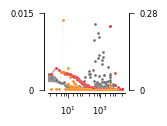

In [460]:
FIG_SIZE = (1, 1)
# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.015]
YLIM_AX2 = [0, 0.28]

pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# 3 secs
# spontaneous
ax1.plot(psd_raw_nv_["freq"], psd_mean_raw_nv, label="vivo", color=COLOR_NV, **pm)
ax1.plot(psd_raw_ns_["freq"], psd_mean_raw_ns, color=COLOR_NS, label="silico", **pm)

# evoked
ax2 = ax1.twinx()
ax2.plot(psd_raw_ne_["freq"], psd_mean_raw_ne, color=COLOR_NE, label="silico", **pm)

# confidence interval
ax1.fill_between(
    psd_raw_nv_["freq"],
    (psd_mean_raw_nv - ci_raw_nv),
    (psd_mean_raw_nv + ci_raw_nv),
    color=COLOR_NV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax1.fill_between(
    psd_raw_ns_["freq"],
    (psd_mean_raw_ns - ci_raw_ns),
    (psd_mean_raw_ns + ci_raw_ns),
    color=COLOR_NS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_ne_["freq"],
    (psd_mean_raw_ne - ci_raw_ne),
    (psd_mean_raw_ne + ci_raw_ne),
    color=COLOR_NE,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# ax1.set_xlabel("frequency [Hz]")
# ax1.set_ylabel("Power ($\mu V^2$/Hz)")
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save (12MB figure)
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L4_raw_norm_psd.svg", **savefig_cfg
)

#### Custom probe

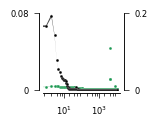

In [461]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.08]
YLIM_AX2 = [0, 0.2]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo
ax2 = ax1.twinx()

# Raw panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

# 3 secs
# spontaneous
# - this order for visibility
ax1.plot(psd_raw_hs2_["freq"], psd_mean_raw_hs2, color=COLOR_HS, label="silico", **pm)
ax2.plot(psd_raw_hv2_["freq"], psd_mean_raw_hv2, label="vivo", color=COLOR_HV, **pm)

# confidence interval
# - this order for visibility
ax1.fill_between(
    psd_raw_hv2_["freq"],
    (psd_mean_raw_hs2 - ci_raw_hs2),
    (psd_mean_raw_hs2 + ci_raw_hs2),
    color=COLOR_HS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_hv2_["freq"],
    (psd_mean_raw_hv2 - ci_raw_hv2),
    (psd_mean_raw_hv2 + ci_raw_hv2),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L4_horv_raw_norm_psd.svg", **savefig_cfg
)

#### plot layer 5

In [462]:
# get L5 data  ***********************

layer = "L5"

# horvath vivo (probe 1)
psd_raw_hv2_ = copy.copy(psd_raw_hv2)
psd_raw_hv2_["power"] = psd_raw_hv2["power"][site_ly_hv2[sites_hv2] == layer, :]

# biophy
psd_raw_hs2_ = copy.copy(psd_raw_hs2)
psd_raw_hs2_["power"] = psd_raw_hs2["power"][site_ly_hs2[sites_hs2] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]

# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]

# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]


# (11s) Divide by total power ***********************

psd_raw_hv2_["power"] = (
    psd_raw_hv2_["power"] / psd_raw_hv2_["power"].sum(axis=1)[:, None]
)
psd_raw_hs2_["power"] = (
    psd_raw_hs2_["power"] / psd_raw_hs2_["power"].sum(axis=1)[:, None]
)
psd_raw_nv_["power"] = psd_raw_nv_["power"] / psd_raw_nv_["power"].sum(axis=1)[:, None]
psd_raw_ns_["power"] = psd_raw_ns_["power"] / psd_raw_ns_["power"].sum(axis=1)[:, None]
psd_raw_ne_["power"] = psd_raw_ne_["power"] / psd_raw_ne_["power"].sum(axis=1)[:, None]
psd_raw_nb["power"] = psd_raw_nb["power"] / psd_raw_nb["power"].sum(axis=1)[:, None]


# (11s) Average over sites ***********************

# horvath
# in vivo
psd_mean_raw_hv2 = np.mean(psd_raw_hv2_["power"], axis=0)
# biophy
psd_mean_raw_hs2 = np.mean(psd_raw_hs2_["power"], axis=0)

# neuropixels
# raw
psd_mean_raw_nv = np.mean(psd_raw_nv_["power"], axis=0)
psd_mean_raw_ns = np.mean(psd_raw_ns_["power"], axis=0)
psd_mean_raw_ne = np.mean(psd_raw_ne_["power"], axis=0)
psd_mean_raw_nb = np.mean(psd_raw_nb["power"], axis=0)

# Calculate 95% confidence intervals  ******************

# horvath
# vivo
# probe 1
n_samples = psd_raw_hv2_["power"].shape[0]
ci_raw_hv2 = 1.96 * np.std(psd_raw_hv2_["power"], axis=0) / np.sqrt(n_samples)

# biophy.
# probe 1
n_samples = psd_raw_hs2_["power"].shape[0]
ci_raw_hs2 = 1.96 * np.std(psd_raw_hs2_["power"], axis=0) / np.sqrt(n_samples)

# neuropixels
# vivo
n_samples = psd_raw_nv_["power"].shape[0]
ci_raw_nv = 1.96 * np.std(psd_raw_nv_["power"], axis=0) / np.sqrt(n_samples)
# biophy. spont.
n_samples = psd_raw_ns_["power"].shape[0]
ci_raw_ns = 1.96 * np.std(psd_raw_ns_["power"], axis=0) / np.sqrt(n_samples)
# biophy. evoked
n_samples = psd_raw_ne_["power"].shape[0]
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)
# synth. buccino
n_samples = psd_raw_nb["power"].shape[0]
ci_raw_nb = 1.96 * np.std(psd_raw_nb["power"], axis=0) / np.sqrt(n_samples)
ci_raw_nb = 1.96 * np.std(psd_raw_nb["power"], axis=0) / np.sqrt(n_samples)

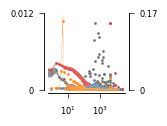

In [474]:
FIG_SIZE = (1, 1)
# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.012]
YLIM_AX2 = [0, 0.17]

pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# 3 secs
# spontaneous
ax1.plot(psd_raw_nv_["freq"], psd_mean_raw_nv, label="vivo", color=COLOR_NV, **pm)
ax1.plot(psd_raw_ns_["freq"], psd_mean_raw_ns, color=COLOR_NS, label="silico", **pm)
ax1.plot(psd_raw_nb["freq"], psd_mean_raw_nb, color=COLOR_NB, label="synth", **pm)

# evoked
ax2 = ax1.twinx()
ax2.plot(psd_raw_ne_["freq"], psd_mean_raw_ne, color=COLOR_NE, label="silico", **pm)

# confidence interval
ax1.fill_between(
    psd_raw_nv_["freq"],
    (psd_mean_raw_nv - ci_raw_nv),
    (psd_mean_raw_nv + ci_raw_nv),
    color=COLOR_NV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax1.fill_between(
    psd_raw_ns_["freq"],
    (psd_mean_raw_ns - ci_raw_ns),
    (psd_mean_raw_ns + ci_raw_ns),
    color=COLOR_NS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax1.fill_between(
    psd_raw_nb["freq"],
    (psd_mean_raw_nb - ci_raw_nb),
    (psd_mean_raw_nb + ci_raw_nb),
    color=COLOR_NB,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_ne_["freq"],
    (psd_mean_raw_ne - ci_raw_ne),
    (psd_mean_raw_ne + ci_raw_ne),
    color=COLOR_NE,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# ax1.set_xlabel("frequency [Hz]")
# ax1.set_ylabel("Power ($\mu V^2$/Hz)")
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")
# save (12MB figure)
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L5_npx_raw_norm_psd.svg", **savefig_cfg
)

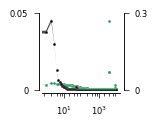

In [475]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.05]
YLIM_AX2 = [0, 0.3]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# horvath vivo
ax2 = ax1.twinx()

# Raw panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

# 3 secs
# spontaneous
# - this order for visibility
ax1.plot(psd_raw_hs2_["freq"], psd_mean_raw_hs2, color=COLOR_HS, label="silico", **pm)
ax2.plot(psd_raw_hv2_["freq"], psd_mean_raw_hv2, label="vivo", color=COLOR_HV, **pm)


# confidence interval
# - this order for visibility
ax1.fill_between(
    psd_raw_hv2_["freq"],
    (psd_mean_raw_hs2 - ci_raw_hs2),
    (psd_mean_raw_hs2 + ci_raw_hs2),
    color=COLOR_HS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_hv2_["freq"],
    (psd_mean_raw_hv2 - ci_raw_hv2),
    (psd_mean_raw_hv2 + ci_raw_hv2),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L5_horv_raw_norm_psd.svg", **savefig_cfg
)

### Plot layer 6

In [476]:
# get L6 data  ***********************

layer = "L6"

# horvath vivo (probe 1)
psd_raw_hv3_ = copy.copy(psd_raw_hv3)
psd_raw_hv3_["power"] = psd_raw_hv3["power"][site_ly_hv3[sites_hv3] == layer, :]

# biophy
psd_raw_hs3_ = copy.copy(psd_raw_hs3)
psd_raw_hs3_["power"] = psd_raw_hs3["power"][site_ly_hs3[sites_hs3] == layer, :]

# neuropixels
# vivo
psd_raw_nv_ = copy.copy(psd_raw_nv)
psd_raw_nv_["power"] = psd_raw_nv["power"][site_ly_nv[sites_nv] == layer, :]

# biophy spont
psd_raw_ns_ = copy.copy(psd_raw_ns)
psd_raw_ns_["power"] = psd_raw_ns["power"][site_ly_ns[sites_ns] == layer, :]

# biophy evoked
psd_raw_ne_ = copy.copy(psd_raw_ne)
psd_raw_ne_["power"] = psd_raw_ne["power"][site_ly_ne[sites_ne] == layer, :]


# (11s) Divide by total power ***********************

psd_raw_hv3_["power"] = (
    psd_raw_hv3_["power"] / psd_raw_hv3_["power"].sum(axis=1)[:, None]
)
psd_raw_hs3_["power"] = (
    psd_raw_hs3_["power"] / psd_raw_hs3_["power"].sum(axis=1)[:, None]
)
psd_raw_nv_["power"] = psd_raw_nv_["power"] / psd_raw_nv_["power"].sum(axis=1)[:, None]
psd_raw_ns_["power"] = psd_raw_ns_["power"] / psd_raw_ns_["power"].sum(axis=1)[:, None]
psd_raw_ne_["power"] = psd_raw_ne_["power"] / psd_raw_ne_["power"].sum(axis=1)[:, None]
psd_raw_nb["power"] = psd_raw_nb["power"] / psd_raw_nb["power"].sum(axis=1)[:, None]


# (11s) Average over sites ***********************

# horvath
# in vivo
psd_mean_raw_hv3 = np.mean(psd_raw_hv3_["power"], axis=0)
# biophy
psd_mean_raw_hs3 = np.mean(psd_raw_hs3_["power"], axis=0)

# neuropixels
# raw
psd_mean_raw_nv = np.mean(psd_raw_nv_["power"], axis=0)
psd_mean_raw_ns = np.mean(psd_raw_ns_["power"], axis=0)
psd_mean_raw_ne = np.mean(psd_raw_ne_["power"], axis=0)
psd_mean_raw_nb = np.mean(psd_raw_nb["power"], axis=0)

# Calculate 95% confidence intervals  ******************

# horvath
# vivo
# probe 1
n_samples = psd_raw_hv3_["power"].shape[0]
ci_raw_hv3 = 1.96 * np.std(psd_raw_hv3_["power"], axis=0) / np.sqrt(n_samples)

# biophy.
# probe 1
n_samples = psd_raw_hs3_["power"].shape[0]
ci_raw_hs3 = 1.96 * np.std(psd_raw_hs3_["power"], axis=0) / np.sqrt(n_samples)

# neuropixels
# vivo
n_samples = psd_raw_nv_["power"].shape[0]
ci_raw_nv = 1.96 * np.std(psd_raw_nv_["power"], axis=0) / np.sqrt(n_samples)
# biophy. spont.
n_samples = psd_raw_ns_["power"].shape[0]
ci_raw_ns = 1.96 * np.std(psd_raw_ns_["power"], axis=0) / np.sqrt(n_samples)
# biophy. evoked
n_samples = psd_raw_ne_["power"].shape[0]
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)
ci_raw_ne = 1.96 * np.std(psd_raw_ne_["power"], axis=0) / np.sqrt(n_samples)
# synth. buccino
n_samples = psd_raw_nb["power"].shape[0]
ci_raw_nb = 1.96 * np.std(psd_raw_nb["power"], axis=0) / np.sqrt(n_samples)
ci_raw_nb = 1.96 * np.std(psd_raw_nb["power"], axis=0) / np.sqrt(n_samples)

##### Plot

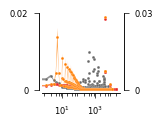

In [491]:
FIG_SIZE = (1, 1)
# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.03]

pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)

# 3 secs
# spontaneous
ax1.plot(psd_raw_nv_["freq"], psd_mean_raw_nv, label="vivo", color=COLOR_NV, **pm)
ax1.plot(psd_raw_ns_["freq"], psd_mean_raw_ns, color=COLOR_NS, label="silico", **pm)

# evoked
ax2 = ax1.twinx()
ax2.plot(psd_raw_ne_["freq"], psd_mean_raw_ne, color=COLOR_NE, label="silico", **pm)

# confidence interval
ax1.fill_between(
    psd_raw_nv_["freq"],
    (psd_mean_raw_nv - ci_raw_nv),
    (psd_mean_raw_nv + ci_raw_nv),
    color=COLOR_NV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax1.fill_between(
    psd_raw_ns_["freq"],
    (psd_mean_raw_ns - ci_raw_ns),
    (psd_mean_raw_ns + ci_raw_ns),
    color=COLOR_NS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_ne_["freq"],
    (psd_mean_raw_ne - ci_raw_ne),
    (psd_mean_raw_ne + ci_raw_ne),
    color=COLOR_NE,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
ax2.set_yticks(YLIM_AX2, YLIM_AX2)

# ax1.set_xlabel("frequency [Hz]")
# ax1.set_ylabel("Power ($\mu V^2$/Hz)")
# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save (12MB figure)
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L6_npx_raw_norm_psd.svg", **savefig_cfg
)

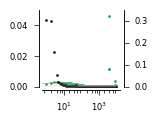

In [415]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.05]
YLIM_AX2 = [0, 0.35]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, figsize=FIG_SIZE)


# Raw panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 2,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.1,
}

# 3 secs
# spontaneous
# - this order for visibility
ax1.plot(psd_raw_hs3_["freq"], psd_mean_raw_hs3, color=COLOR_HS, label="silico", **pm)
# horvath vivo
ax2 = ax1.twinx()
ax2.plot(psd_raw_hv3_["freq"], psd_mean_raw_hv3, label="vivo", color=COLOR_HV, **pm)


# confidence interval
# - this order for visibility
ax1.fill_between(
    psd_raw_hs3_["freq"],
    (psd_mean_raw_hs3 - ci_raw_hs3),
    (psd_mean_raw_hs3 + ci_raw_hs3),
    color=COLOR_HS,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
ax2.fill_between(
    psd_raw_hs3_["freq"],
    (psd_mean_raw_hs3 - ci_raw_hs3),
    (psd_mean_raw_hs3 + ci_raw_hs3),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# axes legend
ax1.set_ylim(YLIM_AX1)
# ax1.set_yticks(YLIM_AX1, YLIM_AX1)
ax2.set_ylim(YLIM_AX2)
# ax2.set_yticks(YLIM_AX2, YLIM_AX2)s

# esthetics
ax1.set_xscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax2.spines["bottom"].set_position(("axes", -0.05))
ax1.spines["left"].set_position(("axes", -0.05))
ax2.spines["left"].set_position(("axes", -0.05))
ax1.spines["right"].set_position(("axes", 1.05))
ax2.spines["right"].set_position(("axes", 1.05))
ax2.yaxis.set_ticks_position("right")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2p_L6_horv_raw_norm_psd.svg", **savefig_cfg
)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
